In [ ]:
%%writefile a.cu

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <opencv2/opencv.hpp>

#define BLOCK_SIZE 16

__global__ void bilinear_interpolation_kernel(const float* img, float* out, const int height, const int width, const float scale_factor)
{
    const int out_x = blockIdx.x * blockDim.x + threadIdx.x;
    const int out_y = blockIdx.y * blockDim.y + threadIdx.y;

    if (out_x >= height || out_y >= width) return;

    const float in_x = out_x / scale_factor;
    const float in_y = out_y / scale_factor;

    const int x1 = static_cast<int>(in_x);
    const int y1 = static_cast<int>(in_y);
    const int x2 = x1 + 1;
    const int y2 = y1 + 1;

    if (x2 >= height || y2 >= width) return;

    const float dx1 = x2 - in_x;
    const float dx2 = in_x - x1;
    const float dy1 = y2 - in_y;
    const float dy2 = in_y - y1;

    const float val1 = dx1 * img[x1 * width + y1] + dx2 * img[x2 * width + y1];
    const float val2 = dx1 * img[x1 * width + y2] + dx2 * img[x2 * width + y2];

    out[out_x * width + out_y] = dy1 * val1 + dy2 * val2;
}

int main()
{
    cv::Mat img = cv::imread("/content/drive/MyDrive/images/img1.jpg", cv::IMREAD_GRAYSCALE);
    cv::Mat out(img.size() * 8, CV_32FC1);

    float* d_img, * d_out;
    cudaMalloc(&d_img, img.rows * img.cols * sizeof(float));
    cudaMalloc(&d_out, out.rows * out.cols * sizeof(float));

    cudaMemcpy(d_img, img.data, img.rows * img.cols * sizeof(float), cudaMemcpyHostToDevice);

    const dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    const dim3 gridSize((out.rows + BLOCK_SIZE - 1) / BLOCK_SIZE, (out.cols + BLOCK_SIZE - 1) / BLOCK_SIZE);

    bilinear_interpolation_kernel <<<gridSize, blockSize>>>(d_img, d_out, img.rows, img.cols, 8.0);

    cudaMemcpy(out.data, d_out, out.rows * out.cols * sizeof(float), cudaMemcpyDeviceToHost);

    cv::imwrite("./output.jpg",img);

    cudaFree(d_img);
    cudaFree(d_out);

    return 0;
}


Overwriting a.cu


In [ ]:
!nvcc -arch=sm_70 -I/usr/local/cuda/include -L/usr/local/cuda/lib64 -lcudart a.cu -o a `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

In [ ]:
!./a

[[ 95.  95.  96. ...  56.  37.  19.]
 [ 97.  96.  97. ...  59.  41.  23.]
 [ 99.  98.  98. ...  63.  45.  27.]
 ...
 [163. 160. 157. ...  48.  48.  49.]
 [163. 160. 157. ...  49.  49.  50.]
 [164. 161. 158. ...  51.  51.  52.]]
0.7669448369999827


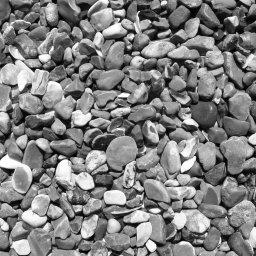

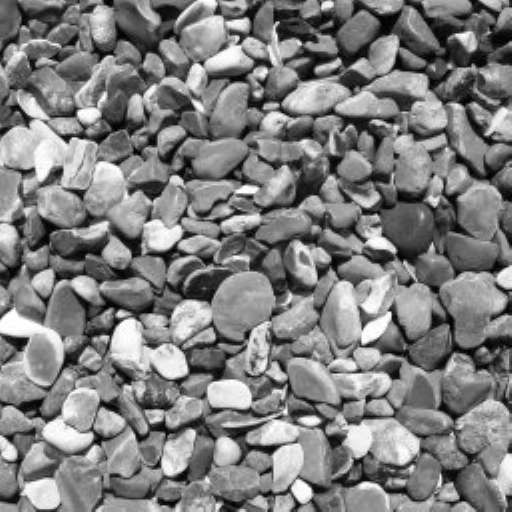

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from time import perf_counter
import math

def worker_s(img, new_img, rescaleFactor):

    step = np.linspace(0,new_img.shape[0]-1,num=img.shape[0]).astype(int)
    isFilled = np.zeros(new_img.shape)

    # Filling original values
    for i,x in enumerate(step):
        for j,y in enumerate(step):
            new_img[x][y]=img[i][j]
            isFilled[x][y]=1
    
    #Filling some row values
    for i in step:
        for j in range(new_img.shape[1]):
            if(isFilled[i][j]):
                continue

            pos = [-1,-1]
            for k in range(1,new_img.shape[1]):
                if(isFilled[i][j-k]):
                    pos[0] = j-k
                    break
            for k in range(1,new_img.shape[1]):
                if(isFilled[i][j+k]):
                    pos[1] = j+k
                    break

            den = pos[1]-pos[0]
            num1 = j-pos[0]
            num2 = pos[1]-j

            f1 = num1/den
            f2 = num2/den

            new_img[i][j]=int(f1*new_img[i][pos[0]]+f2*new_img[i][pos[1]])
            isFilled[i][j]=1

    #Filling all remaining column values
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            if(isFilled[i][j]):
                continue

            pos = [-1,-1]
            for k in range(1,new_img.shape[0]):
                if(isFilled[i-k][j]):
                    pos[0] = i-k
                    break
            for k in range(1,new_img.shape[0]):
                if(isFilled[i+k][j]):
                    pos[1] = i+k
                    break

            den = pos[1]-pos[0]
            num1 = i-pos[0]
            num2 = pos[1]-i

            f1 = num1/den
            f2 = num2/den

            new_img[i][j]=int(f1*new_img[pos[0]][j]+f2*new_img[pos[1]][j])
            isFilled[i][j]=1

    print(new_img)

def linearInterpolation(img, rescaleFactor, num_threads=1):
    img_size = img.shape
    new_size = [i*rescaleFactor for i in img_size]
    new_img_s = np.zeros(new_size)
    new_img_p = np.zeros(new_size)

    start_s=perf_counter()
    worker_s(img,new_img_s,rescaleFactor)
    end_s=perf_counter()
    time_s = end_s-start_s
    print(time_s)

    return new_img_s,new_img_p

img_size = (256,256)
rescaleFactor = 2
img = cv2.imread("/content/drive/MyDrive/images/img1.jpg",0)

new_img_s, new_img_p = linearInterpolation(img, rescaleFactor)

new_img_s = new_img_s.astype(np.uint8)
new_img_p = new_img_p.astype(np.uint8)

cv2_imshow(img)
cv2_imshow(new_img_s)